In [1]:
import pandas as pd
import numpy as np
from jupyterthemes import jtplot

jtplot.style()

import statsmodels.api as sm

In [62]:
df = pd.read_csv('./../data/Monsteruitslagen_Resultaten.csv')
df['datetime'] = pd.to_datetime(df.datum + ' ' + df.tijd)

def convert_tappunt(x):
    x = str(x).lower()
    if 'thermostatische douchemengkraan' in x or 'therm.' in x:
        return 'therm douche'
    if 'douche' in x:
        return 'douche'
    if '1e tappunt' in x:
        return '1e tappunt'
    return 'overige'

def convert_ruimte(x):
    x = str(x).lower()
    if 'kelder' in x:
        return 'kelder'
    if 'kamer' in x:
        return 'kamer'
    if 'appartement' in x:
        return 'appartement'
    if 'technische ruimte' in x:
        return 'technische ruimte'
    if 'kapsalon' in x:
        return 'kapsalon'
    return 'overige'
    
df['tappunt_simple'] = df.tappunt.apply(convert_tappunt)
df['ruimte_simple'] = df.ruimte.apply(convert_ruimte)
df['location_is_Noorderkroon'] = df.locatienaam.str.contains('Noorderkroon')

df_tmp = df[df.component == 'Totaal Legionella spp'].copy()
df_tmp.resultaat = df_tmp.resultaat.str.replace('<100', '0').astype(int)
df_tmp.resultaat.groupby(pd.qcut(df_tmp.tempvoor, 4)).describe()

def get_level(x):
    for i in [0,1,2,3,4]:
        if '{}.'.format(i) in x:
            return i
    return -1
    
df_tmp['app_level'] = df_tmp.ruimte.apply(get_level)
target = (df_tmp.resultaat > 0).astype(int)

In [63]:
target.groupby([df_tmp.tappunt_simple, df_tmp.ruimte_simple]).mean()

tappunt_simple  ruimte_simple
1e tappunt      kelder           0.013514
douche          appartement      0.462810
                kamer            0.291667
                kapsalon         0.000000
                overige          0.000000
overige         appartement      0.000000
                kelder           0.000000
                overige          0.000000
therm douche    appartement      0.514286
                kamer            0.362637
                kelder           0.000000
Name: resultaat, dtype: float64

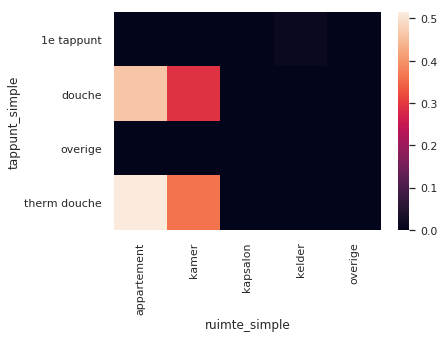

In [64]:
import seaborn as sns; sns.set()
d = target.groupby([df_tmp.tappunt_simple, df_tmp.ruimte_simple]).mean()
d = d.unstack().replace(np.nan, 0)
ax = sns.heatmap(d)

In [30]:
(df_tmp.resultaat > 0).astype(int).groupby(df_tmp['tappunt_simple']).describe()

,count,mean,std,min,25%,50%,75%,max
tappunt_simple,,,,,,,,
1e tappunt,74.0,0.013514,0.116248,0.0,0.0,0.0,0.0,1.0
douche,383.0,0.370757,0.483639,0.0,0.0,0.0,1.0,1.0
overige,4.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [79]:
dummies =  pd.get_dummies(df_tmp[['tappunt_simple', 'ruimte_simple']])
#back stepping
for x in ['tappunt_simple_overige', 'ruimte_simple_overige', 'ruimte_simple_kapsalon', 'ruimte_simple_kelder', 'ruimte_simple_kamer']:
    dummies = dummies.drop(x, axis=1)
model = sm.Logit(df_tmp.resultaat > 0, dummies)
model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.550504
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              resultaat   No. Observations:                  461
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                            3
Date:                Fri, 01 Nov 2019   Pseudo R-squ.:                  0.1110
Time:                        22:40:09   Log-Likelihood:                -253.78
converged:                       True   LL-Null:                       -285.48
                                        LLR p-value:                 1.108e-13
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
tappunt_simple_1e tappunt      -4.2905      1.007     -4.261      0.000      -6.264      -2.317
tappunt_simple_douche          -0.9889      0.177     -5.587      0.000      -1.336      -0.642
tappunt_simple_therm douche    -0.6245      0.195     -3.203      0.001      -1.007      -0.242
ruimte_simple_appartement       0.7865      0.221      3.558      0.000       0.353       1.220
===============================================================================================
"""

In [31]:
(df_tmp.resultaat > 0).astype(int).groupby(df_tmp['ruimte_simple']).describe()

,count,mean,std,min,25%,50%,75%,max
ruimte_simple,,,,,,,,
appartement,157.0,0.471338,0.500775,0.0,0.0,0.0,1.0,1.0
kamer,211.0,0.322275,0.468459,0.0,0.0,0.0,1.0,1.0
kapsalon,7.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
kelder,77.0,0.012987,0.113961,0.0,0.0,0.0,0.0,1.0
overige,9.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [32]:
model = sm.Logit(df_tmp.resultaat > 0, 
                 pd.get_dummies(df_tmp['ruimte_simple']))
model.fit().summary()

         Current function value: 0.534777
         Iterations: 35


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              resultaat   No. Observations:                  461
Model:                          Logit   Df Residuals:                      456
Method:                           MLE   Df Model:                            4
Date:                Fri, 01 Nov 2019   Pseudo R-squ.:                  0.1364
Time:                        22:18:57   Log-Likelihood:                -246.53
converged:                      False   LL-Null:                       -285.48
                                        LLR p-value:                 4.872e-16
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
appartement    -0.1148      0.160     -0.718      0.473      -0.428       0.199
kamer          -0.7433      0.147     -5.046      0.000      -1.032      -0.455
kapsalon      -23.3292    4.4e+04     -0.001      1.000   -8.62e+04    8.62e+04
kelder         -4.3307      1.007     -4.303      0.000      -6.304      -2.358
overige       -21.2859    1.4e+04     -0.002      0.999   -2.74e+04    2.74e+04
===============================================================================
"""

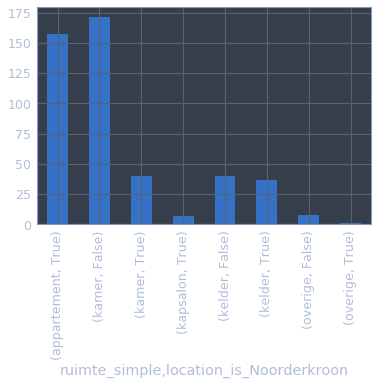

In [33]:
df_tmp.groupby(['ruimte_simple', 'location_is_Noorderkroon']).count()['id'].plot.bar()

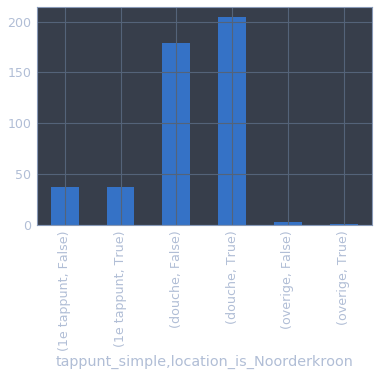

In [10]:
df_tmp.groupby(['tappunt_simple', 'location_is_Noorderkroon']).count()['id'].plot.bar()

In [18]:
df_tmp.groupby(['tappunt_simple', df_tmp.datetime.dt.hour, ]).count()['id']

tappunt_simple  datetime
1e tappunt      9            5
                10          10
                11           9
                12          19
                13          15
                14           9
                15           7
douche          8            1
                9            9
                10          50
                11          72
                12          72
                13          80
                14          85
                15          13
                16           1
overige         11           1
                13           3
Name: id, dtype: int64

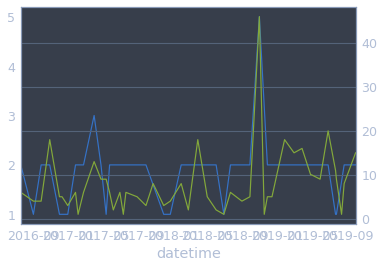

In [29]:
df_1 = df_tmp[df_tmp.tappunt_simple == '1e tappunt']
df_1.groupby([df_1.datetime.dt.date]).count()['id'].plot()
df_1 = df_tmp[df_tmp.tappunt_simple == 'douche']
df_1.groupby([df_1.datetime.dt.date]).count()['id'].plot(secondary_y=True)